## Preprocess

In [30]:
import cv2
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from keras.layers import Dense, Lambda, GlobalAveragePooling2D, Dropout, Activation, Input
from keras.models import Model, Sequential, load_model
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [131]:
train_labels = pd.read_csv('data/labels.csv')
train_len = len(train_labels)
breeds = set(train_labels['breed'])
class_len = len(breeds)
class_to_num = dict(zip(breeds, range(class_len)))
num_to_class = dict(zip(range(class_len), breeds))

In [6]:
dim = 299
X_train = np.zeros((train_len, dim, dim, 3),dtype=np.uint8)
y_train = np.zeros((train_len, class_len),dtype=np.uint8)
for i in tqdm(range(train_len)):
    image_path = 'data/train/{}.jpg'.format(train_labels['id'][i])
    X_train[i] = cv2.resize(cv2.imread(image_path), (dim,dim))
    y_train[i][class_to_num[train_labels['breed'][i]]] = 1

100%|██████████| 10222/10222 [01:29<00:00, 114.81it/s]


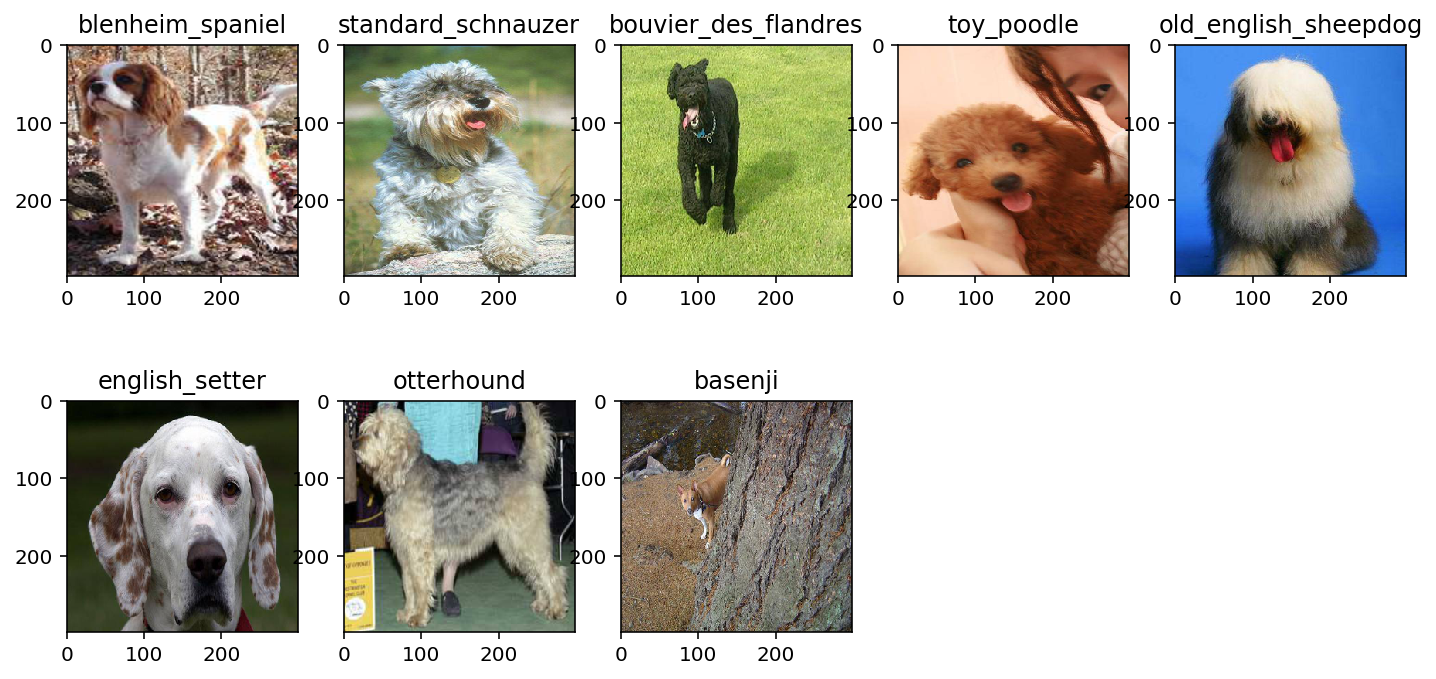

In [11]:
plt.figure(figsize=(12,6))
for i in range(8):
    index = randint(0,train_len-1)
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[index][:,:,::-1])
    plt.title(num_to_class[y_train[index].argmax()])

## Feature Extraction

In [12]:
def feature_extraction(base_model, X):
    model = base_model(include_top=False, input_shape=(dim,dim,3), weights='imagenet')
    inputs = Input((dim, dim, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = model(x)
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs,x)
    features = model.predict(X, batch_size=1, verbose=1)
    return features

In [13]:
"""
#Feature extraction with each dimension of size 299. Do not run this in your own environment. Load precomputed features. 

#1h43m
inception_features_train = feature_extraction(InceptionV3, X_train)
np.save('data/features/inception_features_train.npy', inception_features_train)

#3h10m
xception_features_train = feature_extraction(Xception, X_train)
np.save('data/features/xception_features_train.npy', xception_features_train)

#5h33m
vgg19_features_train = feature_extraction(VGG19, X_train)
np.save('data/features/vgg19_features_train.npy', vgg19_features_train)
"""
pass

In [14]:
#Load features
inception_features_train = np.load('data/features/inception_features_train.npy')
xception_features_train = np.load('data/features/xception_features_train.npy')
vgg19_features_train = np.load('data/features/vgg19_features_train.npy')

#Stack features from different models
features_train = np.concatenate([inception_features_train, xception_features_train, vgg19_features_train], axis=-1)

## Model Construction

In [15]:
features_train.shape

(10222, 4608)

In [16]:
#Fully connected neural network
model = Sequential()
model.add(Dropout(0.5, input_shape=features_train.shape[1:]))
model.add(Dense(class_len, activation='softmax'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
nadam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(optimizer=nadam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features_train, y_train, batch_size=128, epochs=150, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/150
9199/9199 [==============================] - 2s - loss: 4.3625 - acc: 0.1033 - val_loss: 3.6465 - val_acc: 0.4956
Epoch 2/150
9199/9199 [==============================] - 2s - loss: 3.1966 - acc: 0.4461 - val_loss: 2.6405 - val_acc: 0.6950
Epoch 3/150
9199/9199 [==============================] - 2s - loss: 2.3111 - acc: 0.6339 - val_loss: 1.9394 - val_acc: 0.7713
Epoch 4/150
9199/9199 [==============================] - 2s - loss: 1.7250 - acc: 0.7282 - val_loss: 1.4946 - val_acc: 0.8035
Epoch 5/150
9199/9199 [==============================] - 2s - loss: 1.3619 - acc: 0.7678 - val_loss: 1.2203 - val_acc: 0.8133
Epoch 6/150
9199/9199 [==============================] - 2s - loss: 1.1368 - acc: 0.7933 - val_loss: 1.0414 - val_acc: 0.8211
Epoch 7/150
9199/9199 [==============================] - 2s - loss: 0.9730 - acc: 0.8132 - val_loss: 0.9215 - val_acc: 0.8309
Epoch 8/150
9199/9199 [==============================] - 2s - loss: 0.

9199/9199 [==============================] - 2s - loss: 0.0573 - acc: 0.9938 - val_loss: 0.4391 - val_acc: 0.8651
Epoch 130/150
9199/9199 [==============================] - 2s - loss: 0.0575 - acc: 0.9926 - val_loss: 0.4422 - val_acc: 0.8631
Epoch 131/150
9199/9199 [==============================] - 2s - loss: 0.0573 - acc: 0.9929 - val_loss: 0.4393 - val_acc: 0.8563
Epoch 132/150
9199/9199 [==============================] - 2s - loss: 0.0545 - acc: 0.9932 - val_loss: 0.4400 - val_acc: 0.8592
Epoch 133/150
9199/9199 [==============================] - 2s - loss: 0.0547 - acc: 0.9935 - val_loss: 0.4405 - val_acc: 0.8671
Epoch 134/150
9199/9199 [==============================] - 2s - loss: 0.0517 - acc: 0.9943 - val_loss: 0.4420 - val_acc: 0.8622
Epoch 135/150
9199/9199 [==============================] - 2s - loss: 0.0518 - acc: 0.9940 - val_loss: 0.4398 - val_acc: 0.8631
Epoch 136/150
9199/9199 [==============================] - 2s - loss: 0.0508 - acc: 0.9948 - val_loss: 0.4410 - val_ac

In [14]:
model.save('data/models/0.42_ensemble.h5')

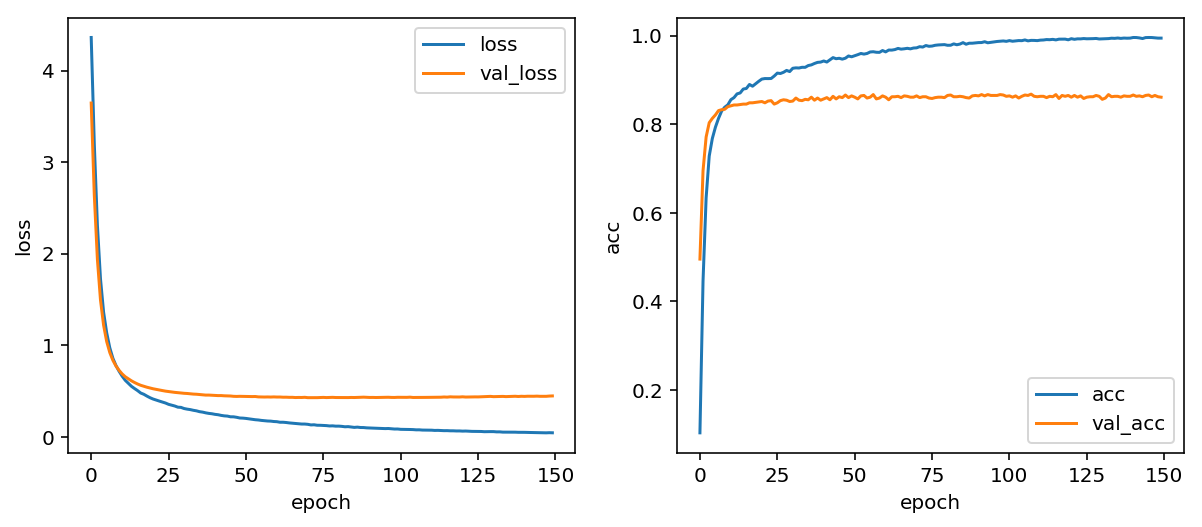

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

## Submission 

In [16]:
sample = pd.read_csv('data/submission/sample.csv')
test_len = len(sample)
X_test = np.zeros((test_len, dim, dim, 3), dtype=np.uint8)
for i in tqdm(range(test_len)):
    image_path = 'data/test/{}.jpg'.format(sample['id'][i])
    X_test[i] = cv2.resize(cv2.imread(image_path), (dim,dim))

100%|██████████| 10357/10357 [01:22<00:00, 125.05it/s]


In [130]:
"""
#Feature extraction with each dimension of size 299. Do not run this in your own environment. Load precomputed features. 

#1h43m 
inception_features_test = feature_extraction(InceptionV3, X_test)
np.save('data/features/inception_features_test.npy', inception_features_test)

#3h10m
xception_features_test = feature_extraction(Xception, X_test)
np.save('data/features/xception_features_test.npy', xception_features_test)

#5h33m
vgg19_features_test = feature_extraction(VGG19, X_test)
np.save('data/features/vgg19_features_test.npy', vgg19_features_test)
"""
pass

In [17]:
#Load features
inception_features_test = np.load('data/features/inception_features_test.npy')
xception_features_test = np.load('data/features/xception_features_test.npy')
vgg19_features_test = np.load('data/features/vgg19_features_test.npy')

#Stack features from different models
features_test = np.concatenate([inception_features_test, xception_features_test, vgg19_features_test], axis=-1)

In [13]:
model = load_model('data/models/0.42_ensemble.h5')

In [18]:
y_pred = model.predict(features_test, batch_size=64)

In [19]:
for i in breeds:
    sample[i] = y_pred[:,class_to_num[i]]

In [20]:
sample.to_csv('data/submission/{}.csv'.format(datetime.now().strftime("%Y%m%d_%Hh%Mm")), index=None)